## Setup

In [173]:
%load_ext autoreload
%load_ext line_profiler
%autoreload 2

import numpy as np
from mpl_toolkits import mplot3d
import matplotlib
import matplotlib.pyplot as plt
import scipy.optimize as optimize

import Bargaining as brg
import bargaining_algorithm as ba
from figures import plot_surplus, model_diffs, model_plot, plot_life_cycle

import numpy as np
import numba as nb
import scipy.optimize as optimize
import copy

from EconModel import EconModelClass
from consav.grids import nonlinspace
from consav import linear_interp, linear_interp_1d
from consav import quadrature

#plt.rcParams.update({'figure.max_open_warning': 0,'text.usetex': False})

# c++ settings
do_cpp = False
do_compile = True
threads = 16

# load models
save_model = True 
load_new   = False
load_old   = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


Compile C++ files

In [184]:
# compile c++ files
if do_cpp & do_compile:
    model = brg.HouseholdModelClass(par={'do_cpp':do_cpp,'num_Ctot':100})
    model.link_to_cpp(force_compile=do_compile)

Set model settings

In [180]:
# settings for models to solve
T = 10
specs = {
    # 'model 1':{'latexname':'$\sigma_{\psi}=0$', 'par':{'sigma_love':0.0,'T':T,'do_cpp':do_cpp,'threads':threads}},
    # #'model 1 old':{'latexname':'$\sigma_{\psi}=0$', 'par':{'sigma_love':0.0,'T':T,'do_cpp':do_cpp,'threads':threads, 'old_bargaining':True}},
    # 'model 2':{'latexname':'$\sigma_{\psi}=0.04$', 'par':{'sigma_love':0.04,'T':T,'do_cpp':do_cpp,'threads':threads}},
    # #'model 2 old':{'latexname':'$\sigma_{\psi}=0.04$', 'par':{'sigma_love':0.04,'T':T,'do_cpp':do_cpp,'threads':threads, 'old_bargaining':True}},
    # 'model 3':{'latexname':'$\sigma_{\psi}=0.1$', 'par':{'sigma_love':0.1,'T':T,'do_cpp':do_cpp,'threads':threads}},
    #'model 3 old':{'latexname':'$\sigma_{\psi}=0.1$', 'par':{'sigma_love':0.1,'T':T,'do_cpp':do_cpp,'threads':threads, 'old_bargaining':True}},
    'model 4':{'latexname':'$\kappa_w=0.3$', 'par':{'div_A_share':0.3,'sigma_love':0.0,'T':T,'do_cpp':False,'threads':threads}},
    'model 4 ccp':{'latexname':'$\kappa_w=0.3$', 'par':{'div_A_share':0.3,'sigma_love':0.0,'T':T,'do_cpp':True,'threads':threads, 'brg_algo':1}},
    #'model 4 old':{'latexname':'$\kappa_w=0.3$', 'par':{'div_A_share':0.3,'sigma_love':0.0,'T':T,'do_cpp':do_cpp,'threads':threads, 'brg_algo':1}},
    #'model 4 lowdim':{'latexname':'$\kappa_w=0.3$', 'par':{'div_A_share':0.3,'sigma_love':0.0,'T':3, 'num_A':5, 'num_love': 6,'do_cpp':do_cpp,'threads':threads}},
    #'model 4 lowdim old':{'latexname':'$\kappa_w=0.3$', 'par':{'div_A_share':0.3,'sigma_love':0.0,'T':3,'num_A':5, 'num_love': 6,'do_cpp':do_cpp,'threads':threads, 'brg_algo':1}},
    
}


Solve models

In [183]:
# solve different models
models = {}
for name,spec in specs.items():
    if ('old' in name) & (load_old):
        print(f'loading {name}...')
        models[name] = brg.HouseholdModelClass(name=name, load=True)
        models[name].spec = spec
    elif ('old' not in name) & (load_new):
        print(f'loading {name}...')
        models[name] = brg.HouseholdModelClass(name=name, load=True)
        models[name].spec = spec
    else:
        print(f'solving {name}...')
        
        # setup model
        models[name] = brg.HouseholdModelClass(name=name,par=spec['par'])
        if spec['do_cpp']: models[name].link_to_cpp(force_compile=False)
        models[name].spec = spec
        
        # solve
        models[name].solve()
        
        # save model
        if save_model:
            models[name].save()

solving model 4...
solving model 4 ccp...


AttributeError: 'types.SimpleNamespace' object has no attribute 'solve'

## Compare bargaining solutions

'Model 1' is solved with the new bargaining algorithm. 'Model 1 old' is solved with the old algorithm. We plot the surplus functions and updating schemes for both models. We also print differences in solutions.

Compare speed of algorithms

In [5]:
# Set index
t=1
iP=10
iL=20
iA=10

idx_couple = lambda iP: (t,iP,iL,iA)
idx_single = (t,iA)

sol = models['model 4'].sol
par = models['model 4'].par

list_couple = copy.deepcopy((sol.Vw_couple,sol.Vm_couple,sol.Cw_priv_couple,sol.Cm_priv_couple,sol.C_pub_couple))
list_raw = copy.deepcopy((sol.Vw_remain_couple, sol.Vm_remain_couple, sol.Cw_priv_remain_couple, sol.Cm_priv_remain_couple, sol.C_pub_remain_couple))
list_single = copy.deepcopy((sol.Vw_single,sol.Vm_single,sol.Cw_priv_single,sol.Cm_priv_single,sol.Cw_pub_single)) # last input here not important in case of divorce

# Get power variables
power_idx = copy.deepcopy(sol.power_idx)
power = copy.deepcopy(sol.power)

# Calculate surplus
Sw = sol.Vw_remain_couple[t,:,iL,iA]-sol.Vw_single[idx_single]
Sm = sol.Vm_remain_couple[t,:,iL,iA]-sol.Vm_single[idx_single]

In [6]:
# Time check_participation_constraints
%timeit  ba.check_participation_constraints(power_idx,power,Sw,Sm,idx_single,idx_couple,list_couple,list_raw,list_single, par)

76.2 µs ± 11.4 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [7]:
# Time check_participation_constraints
%timeit  brg.check_participation_constraints(power_idx,power,Sw,Sm,idx_single,idx_couple,list_couple,list_raw,list_single, par)

76.9 µs ± 7.08 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [8]:
# %timeit brg.check_participation_constraints_old2(power_idx,power,Sw,Sm,idx_single,idx_couple,list_couple,list_raw,list_single, par)

Calculate differences in solutions

In [243]:
def deviation(new,old):
    model_diff = model_diffs(new,old)
    for var in model_diff.sol.__dict__.keys():
        biggest_diff = np.max(np.abs(model_diff.sol.__dict__[var]))
        if biggest_diff == 0.0:
            print(f'Max % dev in {var:24}: {biggest_diff:.8%}')
        else:
            index_of_biggest_diff = np.where(np.abs(model_diff.sol.__dict__[var]) == biggest_diff)
            old_value = np.abs(old.sol.__dict__[var][index_of_biggest_diff][0])
            print(f'Max % dev in {var:24}: {biggest_diff/old_value:.8%}')

In [10]:
# deviation(models['model 1'], models['model 1 old'])

In [11]:
# deviation(models['model 2'], models['model 2 old'])


In [12]:
# model_diff = model_diffs(models['model 2'], models['model 2 old'])
# for var in model_diff.sol.__dict__.keys():
#     print(f'Max diff in {var:24}: {np.max(np.abs(model_diff.sol.__dict__[var])):.8f}')


In [13]:
# model_diff = model_diffs(models['model 3'], models['model 3 old'])
# for var in model_diff.sol.__dict__.keys():
#     print(f'Max diff in {var:24}: {np.max(np.abs(model_diff.sol.__dict__[var])):.8f}')


In [14]:
# model_diff = model_diffs(models['model 4'], models['model 4 old'])
# for var in model_diff.sol.__dict__.keys():
#     print(f'Max diff in {var:24}: {np.max(np.abs(model_diff.sol.__dict__[var])):.8f}')


In [15]:
deviation(models['model 4'], models['model 4 old'])

KeyError: 'model 4 old'

In [ ]:
deviation(models['model 4'], models['model 4 old'])

Max % dev in Vw_single               : 0.00000000%
Max % dev in Vm_single               : 0.00000000%
Max % dev in Cw_priv_single          : 0.00000000%
Max % dev in Cm_priv_single          : 0.00000000%
Max % dev in Cw_pub_single           : 0.00000000%
Max % dev in Cm_pub_single           : 0.00000000%
Max % dev in Cw_tot_single           : 0.00000000%
Max % dev in Cm_tot_single           : 0.00000000%
Max % dev in Vw_trans_single         : 0.00000000%
Max % dev in Vm_trans_single         : 0.00000000%
Max % dev in Cw_priv_trans_single    : 0.00000000%
Max % dev in Cm_priv_trans_single    : 0.00000000%
Max % dev in Cw_pub_trans_single     : 0.00000000%
Max % dev in Cm_pub_trans_single     : 0.00000000%
Max % dev in Cw_tot_trans_single     : 0.00000000%
Max % dev in Cm_tot_trans_single     : 0.00000000%
Max % dev in Vw_couple               : 0.00000083%
Max % dev in Vm_couple               : 0.00000156%
Max % dev in Cw_priv_couple          : 0.00103206%
Max % dev in Cm_priv_couple    

Plot surplus functions

In [16]:
# Set index
t=0
iP=5
iL=20
iA=10

# Set subtitles
subtitles = [name.capitalize() for name in models.keys()]

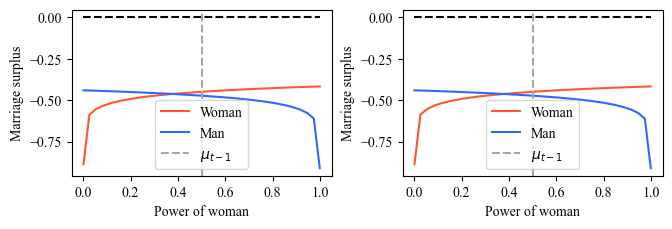

In [190]:
iL=10
model_plot(models, plot_surplus, t, iP, iL, iA, subtitles=subtitles)

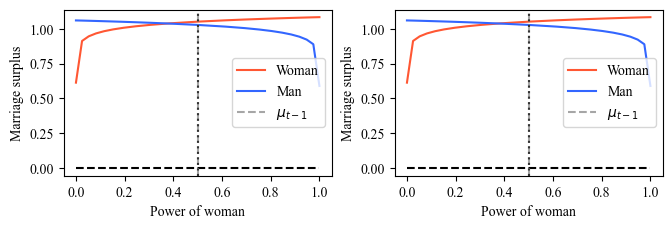

In [191]:
iL=40
model_plot(models, plot_surplus, t, iP, iL, iA, subtitles=subtitles)

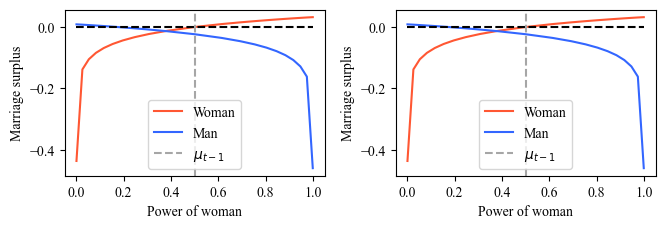

In [192]:
iL=19
model_plot(models, plot_surplus, t, iP, iL, iA, subtitles=subtitles)

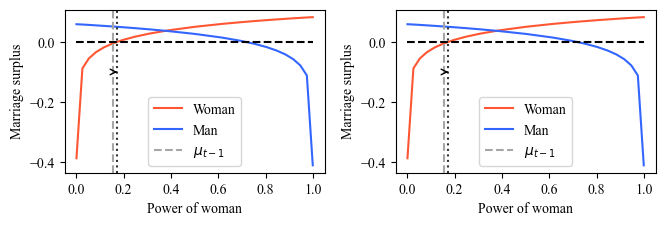

In [193]:
iL=20
iP=5
model_plot(models, plot_surplus, t, iP, iL, iA, subtitles=subtitles)

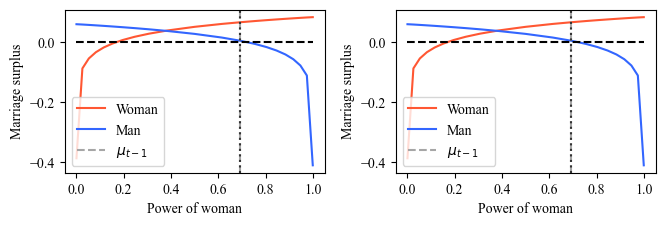

In [194]:
iL=20
iP=12
model_plot(models, plot_surplus, t, iP, iL, iA, subtitles=subtitles)

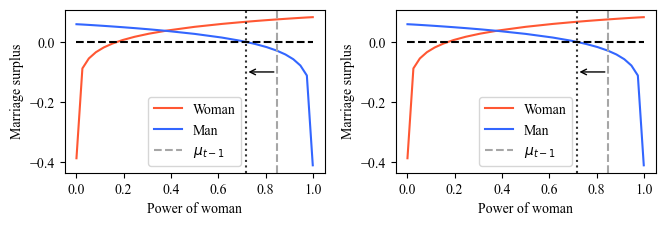

In [195]:
iL=20
iP=15
model_plot(models, plot_surplus, t, iP, iL, iA, subtitles=subtitles)

In [235]:
m = models['model 4 ccp']

iP = 10
iL = 19
t =9

Sw = m.sol.Vw_remain_couple[:,iP,iL,:]-m.sol.Vw_single
Sm = m.sol.Vm_remain_couple[:,iP,iL,:]-m.sol.Vm_single

print((Sm>0).mean())
print((Sw>0).mean())

0.0
0.242


Text(0, 0.5, 'value')

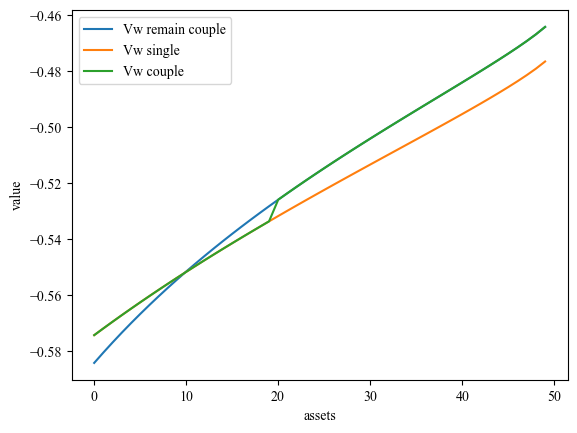

In [236]:
plt.plot(m.sol.Vw_remain_couple[t,iP,iL,:], label='Vw remain couple')
plt.plot(m.sol.Vw_single[t,:], label='Vw single')
plt.plot(m.sol.Vw_couple[t,iP,iL,:], label='Vw couple')

plt.legend()
plt.xlabel("assets")
plt.ylabel("value")

In [233]:
m.sol.power_idx[t,iP,iL,:]

array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10])

Text(0, 0.5, 'value')

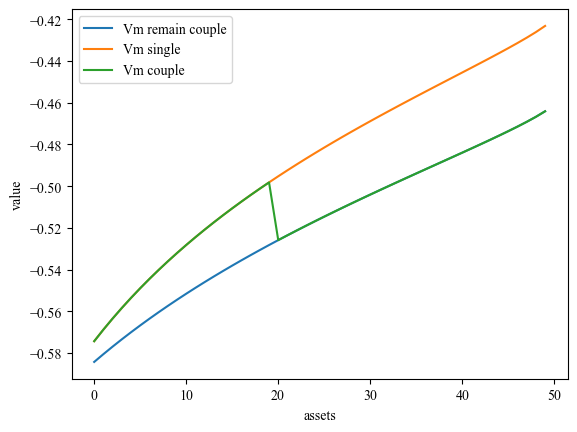

In [237]:
plt.plot(m.sol.Vm_remain_couple[t,iP,iL,:], label='Vm remain couple')
plt.plot(m.sol.Vm_single[t,:], label='Vm single')

plt.plot(m.sol.Vm_couple[t,iP,iL,:], label='Vm couple')

plt.legend()
plt.xlabel("assets")
plt.ylabel("value")

In [242]:
(model_diffs(models['model 4'], models['model 4 ccp']).sol.Vw_couple)

array([[[[-3.55271368e-15, -6.75015599e-13, -1.76836323e-12, ...,
          -2.44747334e-10, -2.87476709e-10, -2.65584887e-10],
         [-3.55271368e-15, -6.75015599e-13, -1.76836323e-12, ...,
          -2.44747334e-10, -2.87476709e-10, -2.65584887e-10],
         [-3.55271368e-15, -6.75015599e-13, -1.76836323e-12, ...,
          -2.44747334e-10, -2.87476709e-10, -2.65584887e-10],
         ...,
         [ 8.41513699e-05,  8.53475997e-05,  8.86729200e-05, ...,
           2.28239577e-04,  2.31359695e-04,  2.31456651e-04],
         [ 8.41517599e-05,  8.53467037e-05,  8.86728821e-05, ...,
           2.28240005e-04,  2.31359911e-04,  2.31456961e-04],
         [ 8.41512189e-05,  8.53476462e-05,  8.86728615e-05, ...,
           2.28239833e-04,  2.31359946e-04,  2.31456721e-04]],

        [[-3.55271368e-15, -6.75015599e-13, -1.76836323e-12, ...,
          -2.44747334e-10, -2.87476709e-10, -2.65584887e-10],
         [-3.55271368e-15, -6.75015599e-13, -1.76836323e-12, ...,
          -2.44747334e

In [244]:
deviation(models['model 4'], models['model 4 ccp'])

Max % dev in Vw_single               : 0.00000026%
Max % dev in Vm_single               : 0.00000129%
Max % dev in Cw_priv_single          : 0.01840952%
Max % dev in Cm_priv_single          : 0.07123960%
Max % dev in Cw_pub_single           : 0.01840952%
Max % dev in Cm_pub_single           : 0.07123960%
Max % dev in Cw_tot_single           : 0.01840952%
Max % dev in Cm_tot_single           : 0.07123960%
Max % dev in Vw_trans_single         : 0.00000026%
Max % dev in Vm_trans_single         : 0.00000129%
Max % dev in Cw_priv_trans_single    : 0.01840952%
Max % dev in Cm_priv_trans_single    : 0.07123960%
Max % dev in Cw_pub_trans_single     : 0.01840952%
Max % dev in Cm_pub_trans_single     : 0.07123960%
Max % dev in Cw_tot_trans_single     : 0.01840952%
Max % dev in Cm_tot_trans_single     : 0.07123960%
Max % dev in Vw_couple               : 7.53904963%
Max % dev in Vm_couple               : 47.34592360%
Max % dev in Cw_priv_couple          : 64.40559441%
Max % dev in Cm_priv_couple  

C:\Users\jmh520\AppData\Local\Temp\ipykernel_13624\930736152.py:10: RuntimeWarning: divide by zero encountered in scalar divide
  print(f'Max % dev in {var:24}: {biggest_diff/old_value:.8%}')


IndexError: index 0 is out of bounds for axis 0 with size 0

Display time taken to solve models

In [200]:
for i in range(1,5):
    model_name = f'model {i}'
    new_algorithm = models[model_name].sol.solution_time[0]
    old_algorithm = models[f'{model_name} old'].sol.solution_time[0]

    print(model_name.capitalize())
    print(f"New algorithm took {new_algorithm:.2f} seconds")
    print(f"Old algorithm took {old_algorithm:.2f} seconds")
    print(f"New algorithm is {old_algorithm - new_algorithm:.2f} seconds faster")
    print(f"Which is a {-100*(new_algorithm - old_algorithm)/old_algorithm:.2f}% improvement")
    print('')

KeyError: 'model 1'

# Investigate deviations in solutions

In [ ]:
new = models['model 4']
old = models['model 4 old']
var = 'Vm_couple'
t=2

model_diff = model_diffs(new,old)
biggest_diff = np.max(np.abs(model_diff.sol.__dict__[var][t]))
index_of_biggest_diff = np.where(np.abs(model_diff.sol.__dict__[var]) == biggest_diff)
new_value = np.abs(new.sol.__dict__[var][index_of_biggest_diff][0])
old_value = np.abs(old.sol.__dict__[var][index_of_biggest_diff][0])
print(f'New value: {new_value:.8f}, Old value: {old_value:.8f}')
print(f'Max % dev in {var}: {biggest_diff/old_value:.8%}')

t, iP, iL, iA = index_of_biggest_diff
t = t[0]
iP = iP[0]
iL = iL[0]
iA = iA[0]
idx = (t,iP,iL,iA)
print(f't = {t}, iP = {iP}, iL = {iL}, iA = {iA}')

New value: 4.02968430, Old value: 4.02968425
Max % dev in Vm_couple: 0.00000114%
t = 2, iP = 13, iL = 20, iA = 21


In [ ]:
# Calculate surplus
Sw_new = new.sol.Vw_remain_couple[t,:,iL,iA]-new.sol.Vw_single[t,iA]
Sw_old = old.sol.Vw_remain_couple[t,:,iL,iA]-old.sol.Vw_single[t,iA]
Sm_new = new.sol.Vm_remain_couple[t,:,iL,iA]-new.sol.Vm_single[t,iA]
Sm_old = old.sol.Vm_remain_couple[t,:,iL,iA]-old.sol.Vm_single[t,iA]
woman = 1
man = 2

# calculate indifference points
Low_w_new, power_at_zero_w_new = brg.find_indifference_point(Sw_new,par, woman)
Low_w_old, power_at_zero_w_old = brg.find_indifference_point(Sw_old,par, woman)
Low_m_new, power_at_zero_m_new = brg.find_indifference_point(Sm_new,par, man)
Low_m_old, power_at_zero_m_old = brg.find_indifference_point(Sm_old,par, man)

print(f'woman indifference point (new / old):  {power_at_zero_w_new:.4f} / {power_at_zero_w_old:.4f}')
print(f'man indifference point (new / old)  :  {power_at_zero_m_new:.4f} / {power_at_zero_m_old:.4f}')
print(f'woman indifference index (new / old):  {Low_w_new} / {Low_w_old}')
print(f'man indifference index (new / old)  :  {Low_m_new} / {Low_m_old}')

woman indifference point (new / old):  0.1974 / 0.1974
man indifference point (new / old)  :  0.7597 / 0.7597
woman indifference index (new / old):  6 / 6
man indifference index (new / old)  :  13 / 13


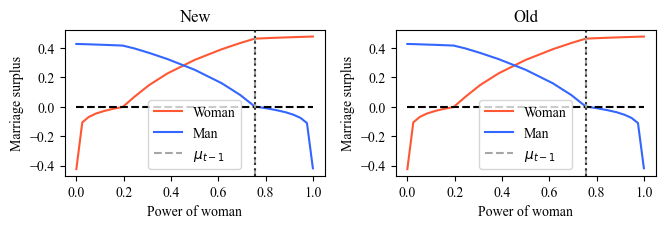

In [ ]:
model_plot([new,old],plot_surplus,t,iP,iL,iA, subtitles=['New','Old'])

In [ ]:
models['model 4'].sol.pre_Ctot_Cw_priv[0]

array([3.33333333e-07, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [ ]:
models['model 4'].sol.Vw_remain_couple[t,iP,iL,iA]

-3.6357094734211968

## Testing new bargaining module

In [ ]:
T=3
specs = {
    'model 4.0':{'latexname':'$\kappa_w=0.3$', 'par':{'div_A_share':0.3,'sigma_love':0.0,'T':T,'do_cpp':do_cpp,'threads':threads, 'brg_algo':0}},
    #'model 4.1':{'latexname':'$\kappa_w=0.3$', 'par':{'div_A_share':0.3,'sigma_love':0.0,'T':T,'do_cpp':do_cpp,'threads':threads, 'brg_algo':1}},
    #'model 4.2':{'latexname':'$\kappa_w=0.3$', 'par':{'div_A_share':0.3,'sigma_love':0.0,'T':T,'do_cpp':do_cpp,'threads':threads, 'brg_algo':2}}
    }

In [ ]:
models = {}
for name,spec in specs.items():
    print(f'solving {name}...')
    
    # setup model
    models[name] = brg.HouseholdModelClass(name=name,par=spec['par'])
    if do_cpp: models[name].link_to_cpp(force_compile=False)
    models[name].spec = spec
    
    # solve
    models[name].solve()

solving model 4.0...


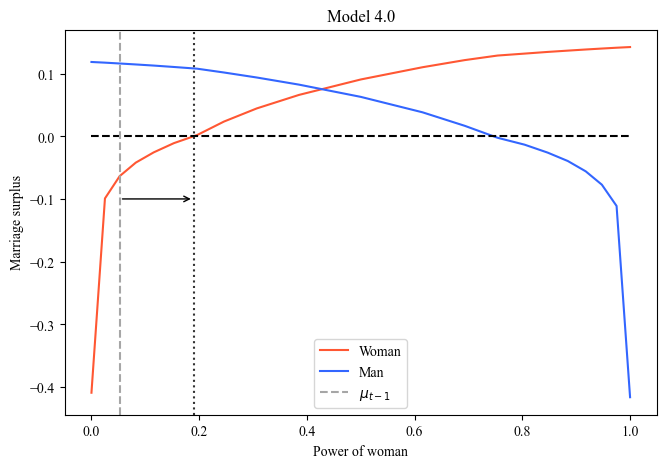

In [ ]:
# Set index
t=-2
iP=2
iL=20
iA=10

# Set subtitles
subtitles = [name.capitalize() for name in models.keys()]
model_plot(models, plot_surplus, t, iP, iL, iA, subtitles=subtitles)

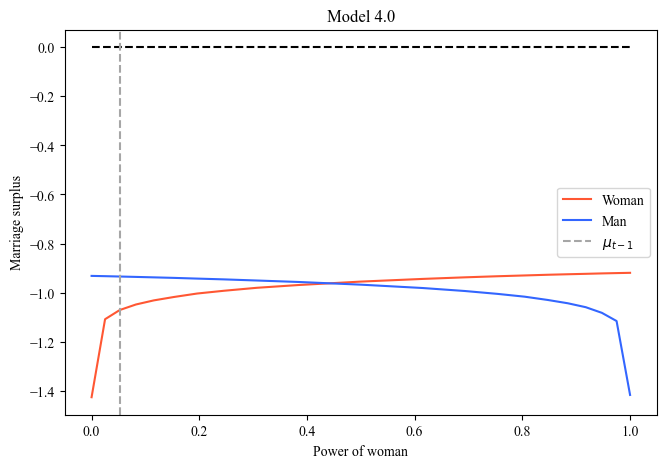

In [ ]:
iL = 0
model_plot(models, plot_surplus, t, iP, iL, iA, subtitles=subtitles)

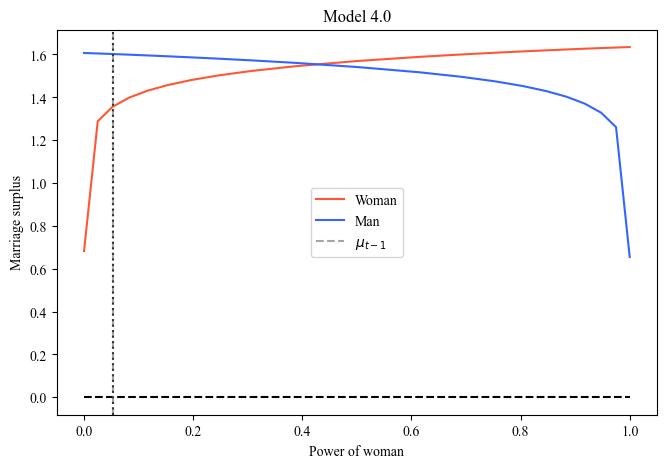

In [ ]:
iL = 35
model_plot(models, plot_surplus, t, iP, iL, iA, subtitles=subtitles)

In [ ]:
new = models['model 4.1']
old = models['model 4.2']
var = 'Vm_couple'

model_diff = model_diffs(new,old)
biggest_diff = np.max(np.abs(model_diff.sol.__dict__[var][t]))
index_of_biggest_diff = np.where(np.abs(model_diff.sol.__dict__[var]) == biggest_diff)
new_value = np.abs(new.sol.__dict__[var][index_of_biggest_diff][0])
old_value = np.abs(old.sol.__dict__[var][index_of_biggest_diff][0])
print(f'New value: {new_value:.8f}, Old value: {old_value:.8f}')
print(f'Max % dev in {var}: {biggest_diff/old_value:.8%}')

t, iP, iL, iA = index_of_biggest_diff
t = t[0]
iP = iP[0]
iL = iL[0]
iA = iA[0]
idx = (t,iP,iL,iA)
print(f't = {t}, iP = {iP}, iL = {iL}, iA = {iA}')

KeyError: 'model 4.1'

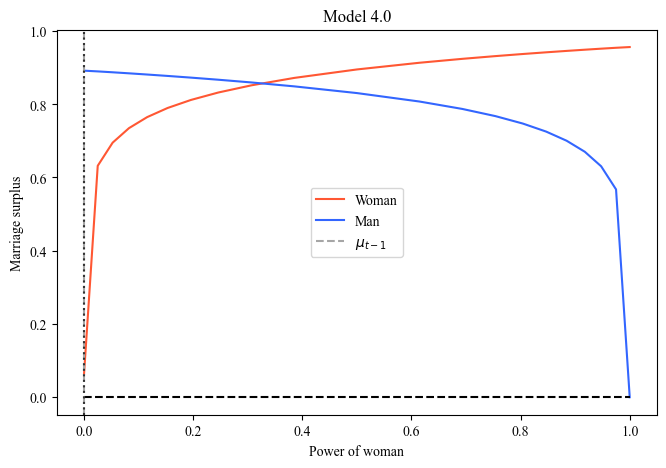

In [ ]:
t = 1 
iP = 0 
iL = 28 
iA = 30
model_plot(models, plot_surplus, t, iP, iL, iA, subtitles=subtitles)

In [ ]:
m = models['model 4.0']
sol = m.sol
par = m.par

t=-2
#iP=2
iL=20
iA=10

idx_couple = lambda iP: (t,iP,iL,iA)
idx_single = (t,iA)

# Unpack lists
remain_Vw = sol.Vw_remain_couple[t,:,iL,iA]
remain_Vm = sol.Vm_remain_couple[t,:,iL,iA]
remain_Cw_priv = sol.Cw_priv_remain_couple[t,:,iL,iA]
remain_Cm_priv = sol.Cm_priv_remain_couple[t,:,iL,iA]
remain_C_pub = sol.C_pub_remain_couple[t,:,iL,iA]

list_couple = copy.deepcopy((sol.Vw_couple,sol.Vm_couple,sol.Cw_priv_couple,sol.Cm_priv_couple,sol.C_pub_couple))
list_raw = copy.deepcopy((remain_Vw,remain_Vm,remain_Cw_priv,remain_Cm_priv,remain_C_pub))
list_single = copy.deepcopy((sol.Vw_single,sol.Vm_single,sol.Cw_priv_single,sol.Cm_priv_single,sol.Cw_pub_single)) # last input here not important in case of divorce

# Get power variables
power_idx = copy.deepcopy(sol.power_idx)
power = copy.deepcopy(sol.power)

power_idx[:]=0
power[:]=0

# Calculate surplus
Sw = sol.Vw_remain_couple[t,:,iL,iA]-sol.Vw_single[idx_single]
Sm = sol.Vm_remain_couple[t,:,iL,iA]-sol.Vm_single[idx_single]

In [ ]:
import bargaining_algorithm as brg_algo
brg_algo.check_participation_constraints(power_idx,power,Sw,Sm,idx_single,idx_couple,list_couple,list_raw,list_single, par)

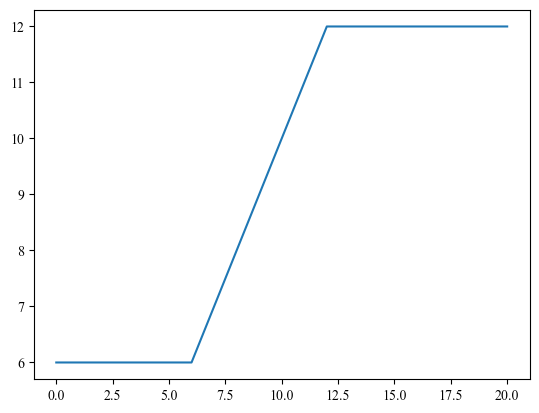

In [ ]:
plt.plot(power_idx[t,:,iL,iA])

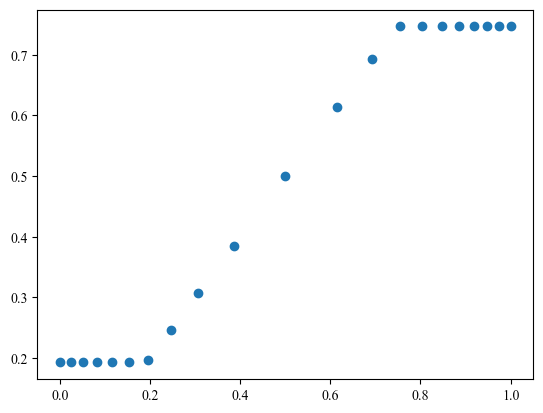

In [ ]:

plt.scatter(par.grid_power, power[t, :, iL, iA]) 